In [9]:
import geopandas
import geoplot
import osmnx as ox
import matplotlib.pyplot as plt

In [11]:
place_name = "Shorewood, Wisconsin, USA"
graph = ox.graph_from_place(place_name)
area = ox.gdf_from_place(place_name)

/home/imbrius/anaconda3/envs/geo_env/lib/python3.8/site-packages/osmnx/boundaries.py:36: UserWarning: The `boundaries` module has been deprecated and will be removed in a future relase. Use the `geocoder` module's `geocode_to_gdf` function instead.
  warnings.warn(msg)


**Cells above this line should only be run once as they hit public web services.**

<Figure size 432x288 with 0 Axes>

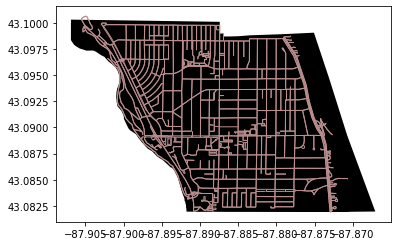

In [13]:
plt.tight_layout()
nodes, edges = ox.graph_to_gdfs(graph)
fix, ax = plt.subplots()
area.plot(ax=ax, facecolor="black")
edges.plot(ax=ax, linewidth=1, edgecolor="#BC8F8F")